# Generate single-cell images

Here, we are going to process the previously ingested microscopy images with the [scPortrait](https://github.com/MannLabs/scPortrait) pipeline to generate single-cell images that we can use to asses autophagosome formation at a single-cell level.

In [18]:
import lamindb as ln
import h5py

from typing import Iterable

from pathlib import Path
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose

ln.track()

→ loaded Transform('9gzJFsXw1f6N0000'), re-started Run('f4pU5nIi...') at 2025-02-24 13:06:35 UTC
→ notebook imports: h5py==3.13.0 lamindb==1.1.0 scportrait==1.1.1.dev0


First, we query for the raw and annotated microscopy images.

In [19]:
input_images = (
    ln.Artifact.filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .filter(suffix=".tif")
)

The experiment contains different genotypes (`WT` and `EI24KO`) that were treated differently (`unstimulated` vs `14h Torin-1`).
For each condition multiple clonal cell lines and imaged multiple FOVs in all of the imaging channels are available.
To properly process this dataset we will need to get single-cell images from each FOV indivdually and tag them with all of the appropriate metadata so that we can identify genotype, treatment condition, clonal cell line and imaging experiment. 

In [20]:
conditions = [
    ln.ULabel.get(name=name)
    for name in set(af.features.get_values()["stimulation"] for af in input_images)
]
cell_line_clones = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["cell_line_clone"] for a in input_images)
]
FOVs = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["FOV"] for a in input_images)
]

In [21]:
input_images[0].features.get_values()

# would be nice to be able to do something equivalent to
# input_images.features.get_values()

{'FOV': 'FOV1',
 'artefact type': 'input images',
 'artifact type': 'input images',
 'cell_line_clone': 'U2OS lcklip-mNeon mCherryLC3B clone 1',
 'channel': 'Alexa488',
 'genotype': 'WT',
 'imaged structure': 'LckLip-mNeon',
 'magnification': '20X',
 'microscope': 'Opera Phenix',
 'stimulation': '14h Torin-1',
 'study': 'autophagy imaging',
 'resolution': 0.597976081}

In [22]:
# this is not working as expected -> should have a lot more features
ln.Artifact.filter(ulabels__name="autophagy imaging").df(features=True)

,uid,key,description,study,resolution,number of single-cells
id,,,,,,
156,D78mnvc00leUXchR0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{157.0}
157,M9K9SMqq8KzcVyQ60000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{160.0}
158,cWztVN7NE7nRxbzi0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{81.0}
159,AJd2Z9JFg6yy8jk50000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{86.0}
160,mpVzuhV5BdmvXV080000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{105.0}
...,...,...,...,...,...,...
150,DkbGSFdQT3AXjqQt0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},NaN
209,P6r2aqhFZomH93uJ0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},{79.0}
215,HHaOZDd3WSa05jZL0000,None,featurized single-cell images,{autophagy imaging},NaN,NaN


By iterating through conditions, celllines and FOVs, we should only have the images showing a single FOV in the 3 imaged channels.

In [23]:
number_of_channels = 3
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            assert len(images) == number_of_channels

We  process these individual FOVs by ingesting our common config file and defining a transform function for each field of view.

In [24]:
# load config file for processing all datasets
config_file_af = ln.Artifact.get(key="input_data_imaging_usecase/config.yml")
config_file_af.description = (
    "config for scportrait for processing of cells stained for autophagy markers"
)
config_file_af.save()

# annotate the config file with the metadata relevant to the study
config_file_af.features.add_values(
    {"study": "autophagy imaging", "artifact type": "scportrait config"}
)

We decorate our custom image procssing function with :func:`~lamindb.tracked` to track data lineage of the input and output Artifacts.

In [25]:
@ln.tracked()
def _process_images(
    config_file_af: ln.Artifact,
    input_artifacts: Iterable[ln.Artifact],
    output_directory: str,
) -> None:
    # Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
    _features = []
    values_to_ignore = ["channel", "imaged structure"]

    for af in input_artifacts:
        features = af.features.get_values()
        features = {
            key: features[key] for key in features.keys() if key not in values_to_ignore
        }
        _features.append(features)
    assert all([_features[0] == f for f in _features])
    shared_features = _features[0]

    # get the paths to the input images
    paths = [
        input_artifacts.filter(ulabels__name=channel_name).one().cache()
        for channel_name in ["DAPI", "Alexa488", "mCherry"]
    ]

    # create a unique identifier for the project based on the annotated features
    unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

    # create the project location
    project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
    Path(project_location).mkdir(parents=True, exist_ok=True)

    project = Project(
        project_location=project_location,
        config_path=config_file_af.cache(),
        segmentation_f=CytosolSegmentationCellpose,
        extraction_f=HDF5CellExtraction,
        overwrite=True,
    )

    # process the project
    project.load_input_from_tif_files(
        paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
    )
    project.segment()
    project.extract()

    # update the annotation to reflect the new data modality
    single_cell_images = f"{project_location}/extraction/data/single_cells.h5"
    annotation = shared_features
    annotation["filetype"] = "h5"  # update filetype to h5
    annotation["number of single-cells"] = h5py.File(single_cell_images, "r")[
        "single_cell_index"
    ].shape[0]
    annotation["channel"] = [
        ln.ULabel.get(name=channel_name)
        for channel_name in ["DAPI", "mCherry", "Alexa488"]
    ]
    annotation["imaged structure"] = [
        ln.ULabel.get(name=structure_name)
        for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
    ]

    artifact = ln.Artifact(
        single_cell_images,
        description="single-cell image dataset of cells stained for autophagy markers",
    )
    artifact.save()
    artifact.features.add_values(annotation)
    artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))


ln.Param(name="output_directory", dtype="str").save()

→ returning existing Param record with same name: 'output_directory'


Param(name='output_directory', dtype='str', is_type=False, created_by_id=4, run_id=28, space_id=1, created_at=2025-02-05 14:37:33 UTC)

Create an output directory where we want to locally store our results before ingesting them.

In [26]:
# define and create an output location
output_directory = "processed_data"
Path(output_directory).mkdir(parents=True, exist_ok=True)

Now we are ready to process all of our input images and upload the generated single-cell image datasets back to lamin.

In [28]:
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            _process_images(
                config_file_af,
                input_artifacts=images,
                output_directory=output_directory,
            )

! cannot infer feature type of: <QuerySet [Artifact(uid='U8ZR9QVb4ZEh0nFh0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_Alexa488_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='yJMlFFYyup0JmBu_FjTa3g', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:58 UTC), Artifact(uid='pn6HkGTNwBpRUcu30000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_DAPI_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='6pvuFREF3CQ8xr8Urak52Q', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:02 UTC), Artifact(uid='1e5B1WWCcNNMZXnB0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_mCherry_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy ma

100%|██████████| 25.3M/25.3M [00:02<00:00, 9.38MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 21.1MB/s]
100%|██████████| 25.3M/25.3M [00:03<00:00, 7.80MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 16.3MB/s]


Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/106 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='2IknVHZf5KECJi3Q0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_Alexa488_zstack001_r002_c010.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='uh537K7rMhMNKW-mti1vjw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:00 UTC), Artifact(uid='2qmCp5xPG6YjG5ZY0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_DAPI_zstack001_r002_c010.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='SOxM7EH80KPXK3hzBxXYLg', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:04 UTC), Artifact(uid='WVlOHa0QHmKdhvwi0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well08_mCherry_zstack001_r002_c010.tif', description='raw image 

Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/96 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='FPCXh3ZA3IPLMaSg0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_Alexa488_zstack001_r001_c003.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='Y1bgVRJGzIEhKFGP54fplA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:33:02 UTC), Artifact(uid='TbdVuGkm8GholosN0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_DAPI_zstack001_r001_c003.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='UFjAP7uBiaM9ivE4hJzHTA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:33:05 UTC), Artifact(uid='cajUzn492AXD5nNy0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_mCherry_zstack001_r001_c003.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/81 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='9yxuLFjlvOPxObat0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_Alexa488_zstack001_r001_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='YX1aIPYndKFiPl5W3OPqfQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:33:04 UTC), Artifact(uid='ZQNtxON435VF4sqD0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_DAPI_zstack001_r001_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='9I6amjQc298AZvER1Z2jjQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:33:07 UTC), Artifact(uid='ogN9beIpq88nmml20000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well08_mCherry_zstack001_r001_c005.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/86 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='LI867lEoCVjTfz0i0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_Alexa488_zstack001_r010_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='vs3t8d40w259zgJRltHlKA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:41 UTC), Artifact(uid='S1vyYJFc9nAgOvRM0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_DAPI_zstack001_r010_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='1mSZ_MMg393bfTvMOl3YMQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:45 UTC), Artifact(uid='4a53mbDGaZnnV6uW0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_mCherry_zstack001_r010_c009.tif', description='raw image 

Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/160 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='EzKoZcZnsX1hvizc0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_Alexa488_zstack001_r010_c010.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='ZPUWq_TI3KWNcVeVz3vOPg', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:43 UTC), Artifact(uid='6SNJ3kKmHxIdbY0J0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_DAPI_zstack001_r010_c010.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='XuugTTV9S5TbJKVMLOaR0w', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:47 UTC), Artifact(uid='L27DL2LQhhhN4AwT0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well08_mCherry_zstack001_r010_c010.tif', description='raw image 

Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/157 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='1rB72PqvOPoKvLf00000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_Alexa488_zstack001_r002_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='4xc4bpAMo0UaM_tc8SciIA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:21 UTC), Artifact(uid='rsoW3GcLbZe7S54v0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_DAPI_zstack001_r002_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='fZ4W2ePHagfGUGCcve98gQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:24 UTC), Artifact(uid='Esuwfnhk7JtCwaMI0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_mCherry_zstack001_r002_c005.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/70 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='Oxa5oKf4zUU6NDQw0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_Alexa488_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='5cfc02GejBaoJ0h3OLWSdw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:22 UTC), Artifact(uid='7nle3IqVf76F1xp90000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_DAPI_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='CmAa139DH_lQ2Plcy4BxXw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:26 UTC), Artifact(uid='OKdwPqnoJ1blWYFQ0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_mCherry_zstack001_r002_c009.tif', description='raw image 

Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/100 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='D78mnvc00leUXchR0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='0aoXxT857VvKAGo9UQo-8g', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:39 UTC), Artifact(uid='cWztVN7NE7nRxbzi0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_DAPI_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='YRjhTt2cBLq3BukWLUKC_w', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:48 UTC), Artifact(uid='mpVzuhV5BdmvXV080000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_mCherry_zstack001_r003_c005.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/69 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='M9K9SMqq8KzcVyQ60000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r004_c007.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='Mm-DsaVdkMbTreUW_ipQBQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:46 UTC), Artifact(uid='AJd2Z9JFg6yy8jk50000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_DAPI_zstack001_r004_c007.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='9_LVWK08Z_D4c1mvIJlTOA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:51 UTC), Artifact(uid='nUeBhiEkKPHKYcrw0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_mCherry_zstack001_r004_c007.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/43 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='V8SRkwipjZyh1n6G0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_Alexa488_zstack001_r001_c002.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='RwasAYhkUEeTVBFrwCbKuw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:51 UTC), Artifact(uid='wsQMmBD0LGs61Icx0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_DAPI_zstack001_r001_c002.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='diUYJPHgU_SvK0zTrrzUlw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:55 UTC), Artifact(uid='U2XUrYzh2XbSSDvr0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_mCherry_zstack001_r001_c002.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/87 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='k6kgocD6RngfryQE0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_Alexa488_zstack001_r001_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='W1Q1RQCUj7j4e9R5Sta4wQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:53 UTC), Artifact(uid='s5tUQcy7Vmk71u7v0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_DAPI_zstack001_r001_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='dIUw6okO0jOq6JcgsxDktA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:56 UTC), Artifact(uid='bwN3Y1OdSHxsiuEH0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row04_Well01_mCherry_zstack001_r001_c009.tif', description='raw image 

Extracting cell batches:   0%|          | 0/2 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/126 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='KAq1UzhmQGNT1ajE0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_Alexa488_zstack001_r001_c007.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='QFmofkisy-sibXAuKrpfRw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:31 UTC), Artifact(uid='n5vNdJj5cASiTC0s0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_DAPI_zstack001_r001_c007.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='f4Vij96NOq7M96SXfyEYXQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:34 UTC), Artifact(uid='691t8j9t2WlaqOi40000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_mCherry_zstack001_r001_c007.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/72 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='DtiDYScl1dL1zcqs0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_Alexa488_zstack001_r001_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='WyabAqK4jeZtTtrQ9rvUeQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:33 UTC), Artifact(uid='9ImieKkFxhw9F63L0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_DAPI_zstack001_r001_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='eXaBPwLJJ--9SyGD7JR0ew', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:36 UTC), Artifact(uid='FjsCGq8IK1BouyZc0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row03_Well01_mCherry_zstack001_r001_c008.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/80 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='jEn1belfVUHZ2ki30000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_Alexa488_zstack001_r005_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='KUhrzT6sDoICDg9cGCUkmg', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:10 UTC), Artifact(uid='IG64YhzALkY6yxW00000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_DAPI_zstack001_r005_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='N2xVJ8pQ9jWoywub8om_iQ', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:14 UTC), Artifact(uid='bhP2KVCsKiHA7a3r0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_mCherry_zstack001_r005_c008.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/33 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%
! cannot infer feature type of: <QuerySet [Artifact(uid='sCvNS4CxaHcmjwWa0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_Alexa488_zstack001_r008_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='xkGVufN-7DDAZOeh4h7LpA', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:12 UTC), Artifact(uid='UdN2eNWWNh3pTA9h0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_DAPI_zstack001_r008_c008.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='aNYMykHkxezUxs-07xgikw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:15 UTC), Artifact(uid='b8HyaXJMogUOo1Gd0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well01_mCherry_zstack001_r008_c008.tif', description='raw image 

Extracting cell batches:   0%|          | 0/1 [00:00<?, ?it/s]

Transferring single cell images to HDF5:   0%|          | 0/47 [00:00<?, ?it/s]

... uploading single_cells.h5: 100.0%


! The following artifacts are both inputs and outputs of Run(uid=u6S41BHOmt5H3qkRcAYj): {Artifact(uid='Oxa5oKf4zUU6NDQw0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_Alexa488_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='5cfc02GejBaoJ0h3OLWSdw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:22 UTC), Artifact(uid='7nle3IqVf76F1xp90000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_DAPI_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='CmAa139DH_lQ2Plcy4BxXw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:26 UTC), Artifact(uid='OKdwPqnoJ1blWYFQ0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_mCherry_zstack001_r002_c009.tif', description='ra

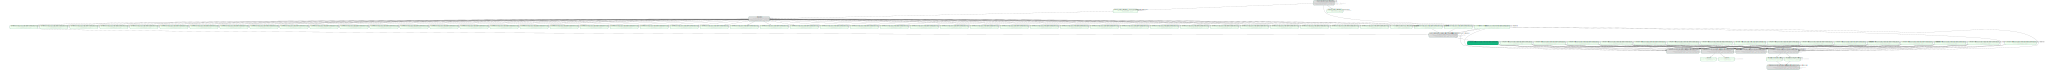

In [30]:
example_artifact = ln.Artifact.filter(
    ulabels=ln.ULabel.get(name="scportrait single-cell images")
)[0]
example_artifact.view_lineage()

In [31]:
ln.finish()

• please hit CTRL + s to save the notebook in your editor .... still waiting . ✓
! cells [(0, 18), (26, 28), (28, 30)] were not run consecutively
→ finished Run('f4pU5nIi') after 17m at 2025-02-24 13:24:09 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/9gzJFsXw1f6N0000
→ to update your notebook from the CLI, run: lamin save /home/lukas/code/lamin-usecases/docs/imaging2.ipynb
